In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob

In [2]:
path_to_data = ('data/')

In [3]:
print('Reading articles...')
articles = pd.concat(map(pd.read_csv, glob(os.path.join(path_to_data+'nyt-articles/', "*.csv"))), axis=0, sort=True).reset_index(drop=True)
print('Reading comments...')
comments = pd.concat(map(pd.read_csv, glob(os.path.join(path_to_data+'nyt-comments/', "*.csv"))), axis=0, sort=True).reset_index(drop=True)

Reading articles...
Reading comments...


C:\Users\naila\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\naila\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\naila\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (14,15,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\naila\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\naila\Anaconda3\lib\site-packages\IP

In [4]:
len(comments)

2176364

In [5]:
len(articles)

9335

# 1. Descriptive statistics

In [6]:
articles['documentType'].value_counts() # some of them are blogposts

article     9168
blogpost     167
Name: documentType, dtype: int64

In [7]:
articles['typeOfMaterial'].value_counts(dropna=False)

News               6219
Op-Ed              1693
Review              513
Editorial           302
briefing            298
Blog                167
News Analysis        48
Brief                34
Obituary (Obit)      29
Question             19
Letter                9
Biography             2
Interview             1
An Appraisal          1
Name: typeOfMaterial, dtype: int64

In [8]:
articles['sectionName'].value_counts(dropna=False)

Unknown                       6380
Politics                       638
Sunday Review                  353
Television                     261
Asia Pacific                   174
Europe                         172
Family                         166
Live                           138
Middle East                     89
Move                            61
Book Review                     60
Economy                         54
Art & Design                    54
Baseball                        52
Eat                             47
Olympics                        45
Soccer                          43
Media                           43
Mind                            42
Lesson Plans                    41
The Daily                       40
Music                           38
Americas                        37
Pro Basketball                  34
Wine, Beer & Cocktails          33
DealBook                        31
Pro Football                    31
Africa                          21
College Basketball  

In [9]:
comments.columns

Index(['approveDate', 'articleID', 'articleWordCount', 'commentBody',
       'commentID', 'commentSequence', 'commentTitle', 'commentType',
       'createDate', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk',
       'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'printPage',
       'recommendations', 'recommendedFlag', 'replyCount', 'reportAbuseFlag',
       'sectionName', 'sharing', 'status', 'timespeople', 'trusted',
       'typeOfMaterial', 'updateDate', 'userDisplayName', 'userID',
       'userLocation', 'userTitle', 'userURL'],
      dtype='object')

In [10]:
comments.head()

,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,...,status,timespeople,trusted,typeOfMaterial,updateDate,userDisplayName,userID,userLocation,userTitle,userURL
0,1491245186,58def1347c459f24986d7c80,716.0,This project makes me happy to be a 30+ year T...,22022598.0,22022598.0,<br/>,comment,1.491237e+09,1.0,...,approved,1.0,0.0,News,1491245186,Rob Gayle,46006296.0,"Riverside, CA",NaN,NaN
1,1491188619,58def1347c459f24986d7c80,716.0,Stunning photos and reportage. Infuriating tha...,22017350.0,22017350.0,NaN,comment,1.491180e+09,1.0,...,approved,1.0,0.0,News,1491188619,Susan A.,29202761.0,<br/>,NaN,NaN
2,1491188617,58def1347c459f24986d7c80,716.0,Brilliant work from conception to execution. I...,22017334.0,22017334.0,<br/>,comment,1.491179e+09,1.0,...,approved,1.0,0.0,News,1491188617,Meta,63944806.0,Raleigh NC,NaN,NaN
3,1491167820,58def1347c459f24986d7c80,716.0,NYT reporters should provide a contributor's l...,22015913.0,22015913.0,<br/>,comment,1.491150e+09,1.0,...,approved,1.0,0.0,News,1491167820,Tom Wyrick,1266184.0,"Missouri, USA",NaN,NaN
4,1491167815,58def1347c459f24986d7c80,716.0,Could only have been done in print. Stunning.,22015466.0,22015466.0,<br/>,comment,1.491147e+09,1.0,...,approved,1.0,0.0,News,1491167815,Joe Sharkey,61121360.0,"Tucson, Arizona",NaN,NaN


In [11]:
comments['commentType'].value_counts()

comment          1595760
userReply         580279
reporterReply        325
Name: commentType, dtype: int64

# 2. Clean data

## 2.1. Keeping only some articles

We keep only the comments written by authors who wrote at least 10 articles in the NYT, and we only focus on Editorials and Opinion Editorials. Some articles were written by several journalists, so we duplicate them -- since we consider the journalists independantly. 

In [12]:
import re

In [13]:
# Keep articles OpEd and Editorial
articles = articles[articles['typeOfMaterial'].isin(['Op-Ed', 'Editorial'])]
len(articles)

1995

In [14]:
# Cleaning articles author name

# duplicate articles if several authors
authors = articles['byline'].str.split(',|and|with', expand=True).add_prefix('author_')

# remove everything before "by, BY, By" (interviewed by, etc.)
for col in authors.columns :
    authors.loc[~authors[col].isna(), col] = authors.loc[~authors[col].isna(), col].apply(lambda x: re.sub(r'.*(by|BY|By)', '', x).strip())

# merge to have article id
authors = pd.merge(authors, articles[['articleID']], left_index=True, right_index=True)

# stack df to have a df with one article-one author per row
authors = authors.set_index(['articleID']).stack().reset_index(level=-1, drop=True).reset_index(name='author')

# manually remove authors which are not real : "M.D" (which is a title), "Unknown"
authors = authors[~authors['author'].isin(['M.D', 'Unknown'])]

# keep authors who wrote 10 or more articles
authors_list = authors['author'].value_counts()[authors['author'].value_counts()>=10].index
authors = authors[authors['author'].isin(authors_list)]

In [15]:
authors['author'].value_counts()

THE EDITORIAL BOARD       258
PAUL KRUGMAN              109
FRANK BRUNI                75
GAIL COLLINS               75
NICHOLAS KRISTOF           72
DAVID BROOKS               72
ROSS DOUTHAT               67
CHARLES M. BLOW            64
ROGER COHEN                61
LIZ SPAYD                  53
BRET STEPHENS              48
DAVID LEONHARDT            46
THOMAS L. FRIEDMAN         37
MICHELLE GOLDBERG          34
THOMAS B. EDSALL           33
TIMOTHY EGAN               30
MAUREEN DOWD               29
EVAN GERSHKOVICH           21
LINDA GREENHOUSE           16
JENNIFER FINNEY BOYLAN     14
ANDREW ROSENTHAL           11
MARGARET RENKL             11
Name: author, dtype: int64

In [16]:
len(authors['author'].unique())

22

In [17]:
# In the comments database, we keep only comments from the authors we kept, using the "articleID" variable.
comments = comments[comments['articleID'].isin(authors['articleID'].unique())]
len(comments)

659776

In [18]:
comments = comments.loc[comments['commentType']=='comment']

In [19]:
comments = comments.join(authors.set_index('articleID'), on='articleID')[['articleID','commentBody','commentID','author']]

In [20]:
comments = comments.drop_duplicates(subset=['commentID','author'], keep='first')

We remove the Editorial Board because we cannot identify it as a unique journalist.

In [21]:
test_set = comments.loc[comments['author']!='THE EDITORIAL BOARD']
len(test_set)

388189

## 2.2. Tokenization of authors names

In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\naila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
test_set['commentBody'] = test_set['commentBody'].str.lower()
test_set['author'] = test_set['author'].str.lower()

C:\Users\naila\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\naila\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
test_set['author_tokens'] = test_set['author'].apply(nltk.word_tokenize)

# Remove "m.", "l.", etc.
def clean_authors_names(author_token):
    issues = "".join([x for x in author_token if len(x)==2])
    if issues!="":
        author_token.remove(issues)
    else :
        pass
test_set['author_tokens'].apply(lambda x: clean_authors_names(x))

C:\Users\naila\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


9          None
10         None
11         None
12         None
13         None
14         None
15         None
16         None
17         None
18         None
19         None
20         None
21         None
22         None
23         None
24         None
25         None
26         None
27         None
28         None
29         None
30         None
31         None
32         None
33         None
34         None
35         None
36         None
37         None
38         None
           ... 
2174957    None
2174958    None
2174959    None
2174960    None
2174961    None
2174962    None
2174963    None
2174964    None
2174965    None
2174966    None
2174967    None
2174968    None
2174969    None
2174970    None
2174971    None
2174972    None
2174973    None
2174974    None
2174975    None
2174976    None
2174977    None
2174978    None
2174979    None
2174980    None
2174981    None
2174982    None
2174983    None
2174984    None
2174985    None
2174986    None
Name: author_tokens, Len

In [25]:
len(test_set)

388189

In [26]:
test_set['ref_author'] = test_set.apply(lambda x: any(i in x.commentBody for i in x.author_tokens), axis=1)
test_set['ref_author'].value_counts()

C:\Users\naila\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


False    308875
True      79314
Name: ref_author, dtype: int64

In [27]:
test_set = test_set.loc[test_set['ref_author']==True].reset_index(drop=True).reset_index()

## 2.3. Extract sentence that contains name of journalist

In [28]:
def extract_sentence(i):
    row=test_set.loc[test_set.index==i]
    sentences=[]
    for author_name in row['author_tokens'][i] :
        if author_name in row['commentBody'][i]:
            sentences.extend(re.findall(r"(?:(?![.?]).|m\.|mr\.|ms\.|dr\.|prof\.)*"+ 
                                        re.escape(author_name) +
                                        r"(?:(?![.?]).|m\.|mr\.|ms\.|dr\.|prof\.)*[\"!?.]", row['commentBody'][i]))
    sentences = ' '.join(set(sentences))
    sentences = re.sub('<br/>', ' ', sentences)
    return sentences

In [29]:
test_set['sentences_author'] = test_set['index'].apply(lambda x: extract_sentence(x))

In [30]:
test_set.to_csv('data/test_set.csv', sep=";")

In [31]:
# labels = test_set.sample(n=300)
# labels.to_csv('data/test_setlabel.csv', sep=";")
# labels['index'].to_csv('data/indexes_setlabel.csv', sep=';')

# Descriptive statistics

## Number of comments

In [32]:
authors_statistics = test_set.groupby('author').agg('sum').reset_index()[['author','ref_author']]

In [33]:
# number of comments in editorials - total
nb_comments_total = comments.groupby('author').agg('count').reset_index()[['author','articleID']].rename(columns={'articleID':'nb_comments'})
nb_comments_total['author'] = nb_comments_total['author'].apply(lambda x: x.lower())

In [34]:
# Number of comments by author
authors_statistics = pd.merge(authors_statistics, nb_comments_total, on='author')
authors_statistics['ref_author_pct'] = authors_statistics['ref_author']/authors_statistics['nb_comments']*100

###  Number of articles

In [35]:
def nb_articles(df):
    nb_comments_articles = df.groupby(('author','articleID')) \
                                        .agg('count').reset_index()[['author','articleID','commentID']] \
                                        .rename(columns={'commentID':'nb_comments'})
    nb_comments_articles['author'] = nb_comments_articles['author'].apply(lambda x: x.lower())
    
    nb_articles = nb_comments_articles.groupby('author').agg('count').reset_index()[['author','articleID']].rename(columns={'articleID':'nb_articles'})
    
    nb_comments_articles=nb_comments_articles.groupby('author').agg('mean').reset_index().rename(columns={"nb_comments":'nb_comments_by_article'})

    return nb_comments_articles, nb_articles

In [36]:
nb_comments_total, nb_articles_total = nb_articles(comments)
nb_comments_test, nb_articles_test = nb_articles(test_set)

C:\Users\naila\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


In [37]:
authors_statistics = pd.merge(authors_statistics, nb_articles_total, on="author").rename(columns={'nb_articles':'nb_articles_test'})
authors_statistics = pd.merge(authors_statistics, nb_articles_total, on="author").rename(columns={'nb_articles':'nb_articles_total'})
authors_statistics['articles_pct'] = authors_statistics['nb_articles_test']/authors_statistics['nb_articles_total']*100

In [38]:
authors_statistics = pd.merge(authors_statistics, nb_comments_test,on="author").rename(columns={'nb_comments_by_article':'nb_comments_by_article_test'})
authors_statistics = pd.merge(authors_statistics, nb_comments_total,on="author").rename(columns={'nb_comments_by_article':'nb_comments_by_article_total'})
authors_statistics['nb_comments_article_pct'] = authors_statistics['nb_comments_by_article_test']/authors_statistics['nb_comments_by_article_total']*100

In [39]:
authors_statistics

,author,ref_author,nb_comments,ref_author_pct,nb_articles_test,nb_articles_total,articles_pct,nb_comments_by_article_test,nb_comments_by_article_total,nb_comments_article_pct
0,andrew rosenthal,170.0,3094,5.494505,10,10,100.0,18.888889,309.400000,6.105006
1,bret stephens,3828.0,14651,26.127909,47,47,100.0,81.446809,311.723404,26.127909
2,charles m. blow,8470.0,39395,21.500190,61,61,100.0,138.852459,645.819672,21.500190
3,david brooks,17976.0,47493,37.849788,71,71,100.0,253.183099,668.915493,37.849788
4,david leonhardt,1394.0,18194,7.661867,46,46,100.0,30.304348,395.521739,7.661867
5,evan gershkovich,23.0,743,3.095559,20,20,100.0,1.769231,37.150000,4.762398
6,frank bruni,5857.0,36117,16.216740,72,72,100.0,81.347222,501.625000,16.216740
7,gail collins,3920.0,27493,14.258175,71,71,100.0,55.211268,387.225352,14.258175
8,jennifer finney boylan,194.0,2347,8.265871,14,14,100.0,13.857143,167.642857,8.265871
9,linda greenhouse,434.0,3042,14.266930,15,15,100.0,28.933333,202.800000,14.266930


### Graphs

In [40]:
import matplotlib.pyplot as plt

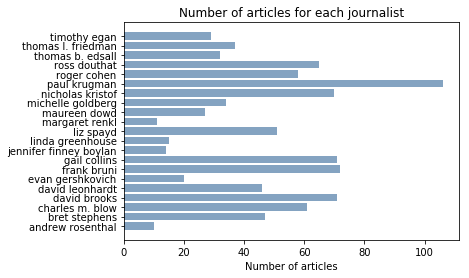

In [41]:
plt.barh(authors_statistics['author'], authors_statistics['nb_articles_total'], color=(0.2, 0.4, 0.6, 0.6))
plt.title("Number of articles for each journalist")
plt.xlabel('Number of articles')
plt.show()


We represent the number of comments by article for each author. The "total comments" columns correspond to the number of comments that don't contain the journalist's name by article. The two bargraphs are stacked so that we can see the proportionality.

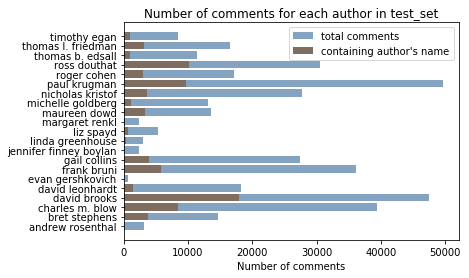

In [42]:
plt.barh(authors_statistics['author'], authors_statistics['nb_comments'], color=(0.2, 0.4, 0.6, 0.6), label='total comments')
plt.barh(authors_statistics['author'], authors_statistics['ref_author'], color='#7f6d5f', label="containing author's name")

plt.title("Number of comments for each author in test_set")
plt.xlabel('Number of comments')
plt.legend()
plt.show()

# in proportion of all comments, some journalists are more quoted than others

We represent the mean of number of comments by article for each author. The "total comments" columns correspond to mean of number of comments that don't contain the journalist's name by article. The two bargraphs are stacked so that we can see the proportionality.

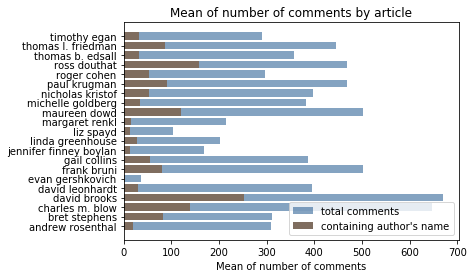

In [43]:
plt.barh(authors_statistics['author'], authors_statistics['nb_comments_by_article_total'], color=(0.2, 0.4, 0.6, 0.6), label='total comments')
plt.barh(authors_statistics['author'], authors_statistics['nb_comments_by_article_test'], color='#7f6d5f', label="containing author's name")

plt.title("Mean of number of comments by article")
plt.xlabel('Mean of number of comments')
plt.legend()
plt.show()

# Final labels

In [44]:
final = pd.read_csv('data/final_set.csv', sep=",")

In [45]:
final['sentiment_str'] = final['sentiment_predicted'].map({0:'negative',2:'neutral',1:'positive'})

In [46]:
final = final.groupby(['author','sentiment_str']).agg('count').reset_index()\
            .pivot(index='author',columns='sentiment_str', values='text').reset_index()
final['nb_comments'] = final.sum(axis=1)

for sentiment in ['positive','negative','neutral']:
    final[sentiment+'_pct'] = final[sentiment]/final['nb_comments']

Here we represent the number of negative, positive, and neutral comments for each author.

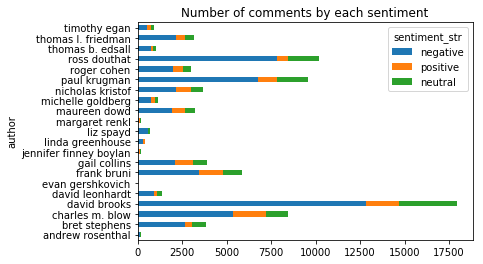

In [47]:
final.set_index('author')[['negative','positive','neutral']]\
                .plot.barh(stacked=True, title="Number of comments by each sentiment")

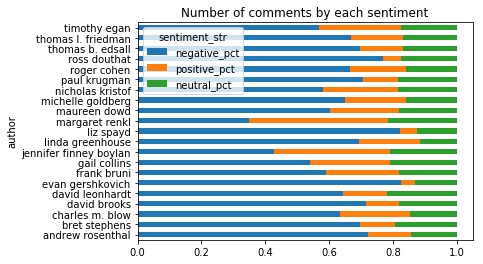

In [48]:
final.set_index('author')[['negative_pct','positive_pct','neutral_pct']]\
                .plot.barh(stacked=True, title="Number of comments by each sentiment")

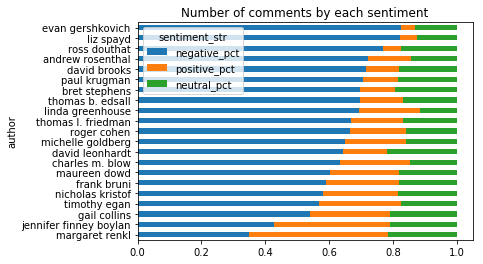

In [49]:
final.sort_values('negative_pct').set_index('author')[['negative_pct','positive_pct','neutral_pct']]\
                .plot.barh(stacked=True, title="Number of comments by each sentiment")

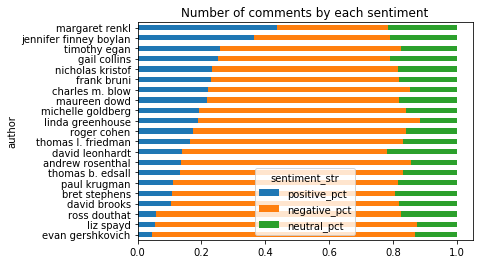

In [50]:
final.sort_values('positive_pct').set_index('author')[['positive_pct','negative_pct','neutral_pct']]\
                .plot.barh(stacked=True, title="Number of comments by each sentiment")